In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc # Quasi Monte Carlo
from scipy.interpolate import griddata           # Interpolación para mapeo en una malla

import time # Measure time

from PINN_2D_Laplace import PhysicsInformedNN

# Muestreo en el cuadrado

In [3]:
# Limites inferiores y superiores del cuadrado

xl, xr = 0, 1
yd, yu = 2, 3

# Número de nodos por lado
n = 7

# Muestreo sobre la dirección horizontal y vertical
h = np.random.uniform(low = xl, high = xr, size = 2*n)
v = np.random.uniform(low = yd, high = yu, size = 2*n)

# Construcción de los lados
l1 = np.array( [xr*np.ones(n), v[:n] ] ).T
l2 = np.array( [h[:n], yd*np.ones(n) ] ).T
l3 = np.array( [xl*np.ones(n), v[n:] ] ).T
l4 = np.array( [h[n:], yu*np.ones(n) ] ).T

# Agrupamiento de los puntos de frontera aleatorios
bdy = np.concatenate([l1, l2, l3, l4])


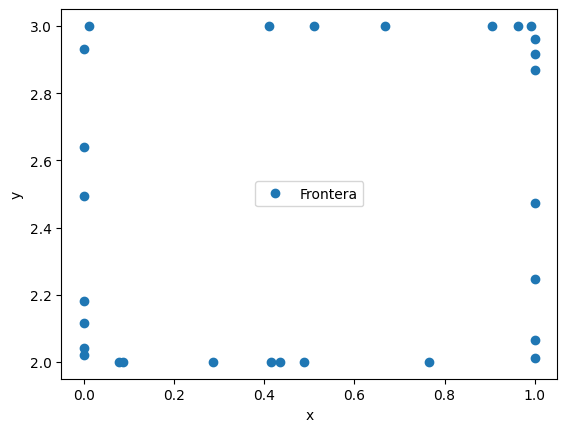

In [4]:
plt.plot(bdy[:,0], bdy[:,1], 'o', label = 'Frontera')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()

# plt.savefig('bdy.png')
plt.show()

## Diferentes elecciones de los puntos interiores

In [6]:
N = 2**5

In [7]:
sobol = qmc.Sobol(d=2, scramble = True)
sobol_smp = sobol.random(N) # Es necesario que N sea una potencia de 2
sobol_smp = qmc.scale(sobol_smp, [xl, yd], [xr, yu])

In [8]:
lhs = qmc.LatinHypercube(d=2, scramble = True)
lhs_smp = lhs.random(N)
lhs_smp = qmc.scale(lhs_smp, [xl, yd], [xr, yu])

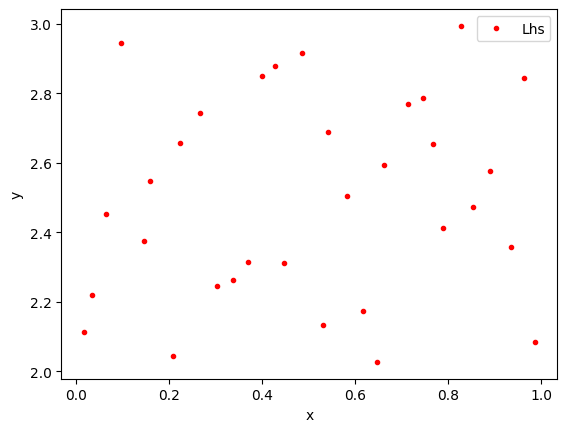

In [9]:
plt.plot(lhs_smp[:,0], lhs_smp[:,1], '.r', label = 'Lhs')
# plt.plot(sobol_smp[:,0], sobol_smp[:,1], '.g', label = 'Sobol')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plt.savefig('lhs.png')
plt.show()

## Elección conjunta

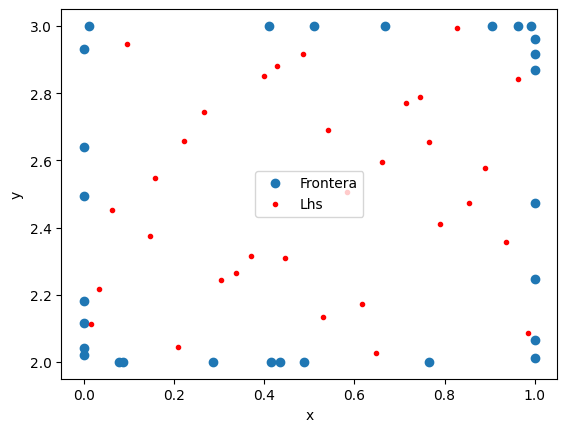

In [11]:
plt.plot(bdy[:,0], bdy[:,1], 'o', label = 'Frontera')
plt.plot(lhs_smp[:,0], lhs_smp[:,1], '.r', label = 'Lhs')
# plt.plot(sobol_smp[:,0], sobol_smp[:,1], '.g', label = 'Sobol')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plt.savefig('bdy_lhs.png')
plt.show()

# Ejecución

In [13]:
if __name__ == "__main__":  
    
    #-------------------------------
    N_bdy = 40   # Puntos de entrenamiento en la frontera
    N_int = 200  # Puntos de colocación en el dominio interior

    NN = 40
    Npx,Npy = NN+1, NN+1
    
    Ne = 20        # Neuronas por capa oculta

    coef = [1, 0 , 1, 0, 0, 0] # Coeficientes de la PDE
    layers = [2, Ne, Ne, Ne, 1]  # Arquitectura: entrada, 3 ocultas, salida
    epochs = 2000
    lr = 1e-3

    #-------------------------------
    # Mostrar resumen de parámetros en consola
    print('  ')
    print('---------------------------------------------')
    print('              PROBLEMA ELÍPTICO              ')
    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de frontera          N_bdy =', N_bdy)
    print('  Puntos de colocalización    N_int =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                             ')
    print('  Capas =', layers)
    print('---------------------------------------------')
    print('  ')

    # .----------------------------------------------.
    # |           MALLA: DOMINIO 2D                  |
    # .______________________________________________.

    #.-----------------------------------------------.
    # |      SOLUCION EXACTA EN UN GRID             |
    # .______________________________________________.

    # .----------------------------------------------.
    # |           MALLA: DOMINIO 2D                  |
    # .______________________________________________.

    # Definición del dominio: [-1, 1] x [-1, 1]
    xIni = -1.0; xFin = 1.0
    yIni = -1.0; yFin = 1.0

    # Malla para predicción
    xp = np.linspace(xIni, xFin, num=Npx)
    yp = np.linspace(yIni, yFin, num=Npy)
    XP, YP = np.meshgrid(xp, yp)

    # .----------------------------------------------.
    # |       SOLUCIÓN EXACTA (para referencia)      |
    # .______________________________________________.

    # Solución exacta en la malla de predicción
    UP_Exact = np.zeros((Npy, Npx))
    for j in range(Npy):
        for i in range(Npx):
            UP_Exact[j, i] = np.exp(xp[i]) * np.cos(yp[j])

    # [3] Puntos de predicción y solución exacta
    Xp_star = np.hstack((XP.flatten()[:, None], YP.flatten()[:, None]))
    up_star = UP_Exact.flatten()[:, None]
    
    # .----------------------------------------------.
    # |     PUNTOS DE ENTRENAMIENTO Y COLOCACIÓN     |
    # .______________________________________________.

    xl, xr = -1, 1
    yd, yu = -1, 1

    # Número de nodos por lado
    n = N_bdy//4

    # Muestreo sobre la dirección horizontal y vertical
    h = np.random.uniform(low = xl, high = xr, size = 2*n)
    v = np.random.uniform(low = yd, high = yu, size = 2*n)

    # Construcción de los lados
    l1 = np.array( [xr*np.ones(n), v[:n] ] ).T
    l2 = np.array( [h[:n], yd*np.ones(n) ] ).T
    l3 = np.array( [xl*np.ones(n), v[n:] ] ).T
    l4 = np.array( [h[n:], yu*np.ones(n) ] ).T

    # Agrupamiento de los puntos de frontera aleatorios
    X_u_train = np.concatenate([l1, l2, l3, l4])

    u_train = np.zeros((4*n, 1))
    for i in range(X_u_train.shape[0]):
        u_train[i, 0] = np.exp(X_u_train[i,0])*np.cos(X_u_train[i,1])

    # Puntos de colocacción
    lhs = qmc.LatinHypercube(d=2, scramble = True)
    lhs_smp = lhs.random(N_int)
    X_f_train = qmc.scale(lhs_smp, [xl, yd], [xr, yu])

    rhs_train = np.zeros((N_int,1))
    

    # .================================================================.
    # | [S.2]                  APROXIMACIÓN                            |
    # .================================================================.

    # .----------------------------------------------.
    # |     ENTRENAMIENTO DEL MODELO (PINN)          |
    # .______________________________________________.

    #  Construcción de la red neuronal con condiciones físicas
    model = PhysicsInformedNN(X_u_train, u_train,
                              X_f_train, rhs_train,
                              layers, epochs, lr)

    # Entrenamiento de la red neuronal
    start_time = time.time()
    model.train()
    elapsed = time.time() - start_time

    # .----------------------------------------------.
    # |         PREDICCIÓN SOBRE NUEVA MALLA         |
    # .______________________________________________.

    up_pred = model.predict(Xp_star)   # un solo vector de predicciones
    UP_pred = griddata(Xp_star, up_pred.flatten(), (XP, YP), method='cubic')  # 2D

    # .----------------------------------------------.
    # |     CÁLCULO DE ERRORES L2 Y MÁXIMO           |
    # .______________________________________________.

    error_u   = np.linalg.norm(up_star - up_pred, 2) / np.linalg.norm(up_star, 2)
    error_max = np.linalg.norm(up_star - up_pred, np.inf)

    # .================================================================.
    # | [S.3]              VISUALIZACIÓN DE RESULTADOS                 |
    # .================================================================.

    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de frontera          N_bdy =', N_bdy)
    print('  Puntos de colocalización    N_int =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                             ')
    print('  Capas =', layers)
    print('  Tiempo de entrenamiento: %.4f segundos' % (elapsed))
    print('---------------------------------------------')
    print('  MALLA DE PREDICCIÓN:', Npx * Npy)
    print('  Nodos en dirección x     Nx =', Npx)
    print('  Nodos en dirección y     Ny =', Npy)
    print('---------------------------------------------')
    print('  Norma L2       Norma máx')
    print('  %e    %e' % ( error_u, error_max))
    print('---------------------------------------------')
    print('  Tiempo de entrenamiento: %.4f segundos' % (elapsed))
    print('---------------------------------------------')
    print('  ')

  
---------------------------------------------
              PROBLEMA ELÍPTICO              
---------------------------------------------
  ENTRENAMIENTO:                             
  Puntos de frontera          N_bdy = 40
  Puntos de colocalización    N_int = 200
---------------------------------------------
  RED NEURONAL:                             
  Capas = [2, 20, 20, 20, 1]
---------------------------------------------
  
Epoch 0, Loss: 1.85411e+00,  U_loss: 1.82381e+00, f_loss: 3.02963e-02
Epoch 100, Loss: 2.01282e-01,  U_loss: 1.56638e-01, f_loss: 4.46436e-02
Epoch 200, Loss: 1.51282e-01,  U_loss: 1.42634e-01, f_loss: 8.64812e-03
Epoch 300, Loss: 1.29404e-01,  U_loss: 1.26417e-01, f_loss: 2.98662e-03
Epoch 400, Loss: 1.10733e-01,  U_loss: 1.01209e-01, f_loss: 9.52430e-03
Epoch 500, Loss: 9.34890e-02,  U_loss: 8.22032e-02, f_loss: 1.12858e-02
Epoch 600, Loss: 7.40212e-02,  U_loss: 6.18000e-02, f_loss: 1.22212e-02
Epoch 700, Loss: 4.52521e-02,  U_loss: 3.41401e-02, f_loss:

In [14]:
loss_h, u_loss_h, f_loss_h = model.history()

# Gráficas

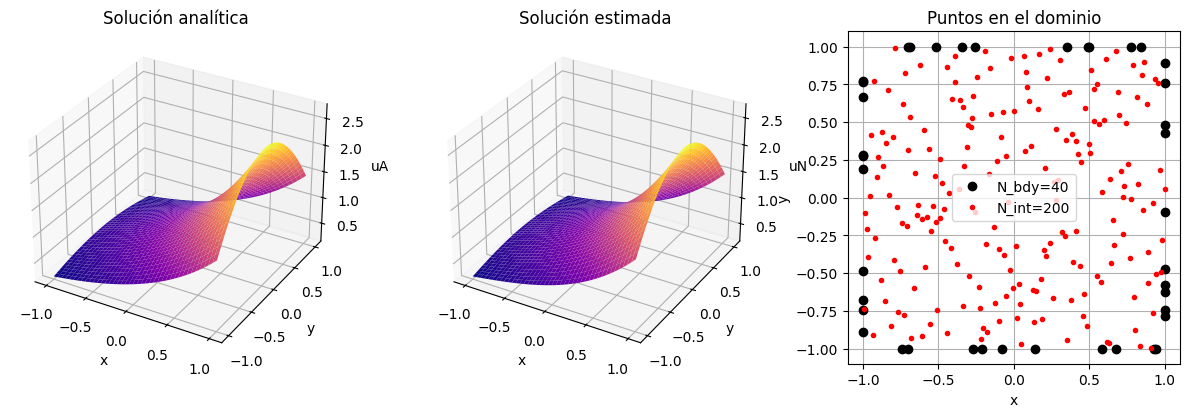

In [16]:
from mpl_toolkits.mplot3d import Axes3D          # Gráficos 3D con matplotlib

# .----------------------------------------------.
#  Graficar resultados
# .----------------------------------------------.
#  - Subplot 1: Solución analítica
#  - Subplot 2: Solución predicha
#  - Subplot 3: Distribución de puntos
fig = plt.figure(figsize=(12, 4))

# Subplot 1: Solución analítica
ax1 = fig.add_subplot(131, projection='3d')
Xp, Yp = np.meshgrid(xp, yp)

uA = up_pred.reshape(XP.shape)
ax1.plot_surface(Xp, Yp, UP_Exact, cmap='plasma')
# ax1.scatter(X_u_train[:,0], X_u_train[:,1] , u_train[:,0], color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('uA')
ax1.set_title('Solución analítica')

# Subplot 2: Solución estimada por la red
ax2 = fig.add_subplot(132, projection='3d')

Z_pred = model.predict(Xp_star)
ZP = Z_pred.reshape(XP.shape)

ax2.plot_surface(Xp, Yp, ZP, cmap='plasma')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('uN')
ax2.set_title('Solución estimada')

# Subplot 3: Distribución de puntos de entrenamiento

ax3 = fig.add_subplot(133)
str1 = f'N_bdy={N_bdy}'
str2 = f'N_int={N_int}'

ax3.plot(X_u_train[:,0], X_u_train[:,1], 'ok', label=str1) # Boundry
ax3.plot(X_f_train[:,0], X_f_train[:,1], '.r', label=str2) # Latin HyperCube

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Puntos en el dominio')
ax3.set_aspect('equal')
ax3.legend()
ax3.grid(True)


plt.tight_layout()

plt.savefig('Sol_Cuadrado.png')
plt.show()

## Gráfica de los errores

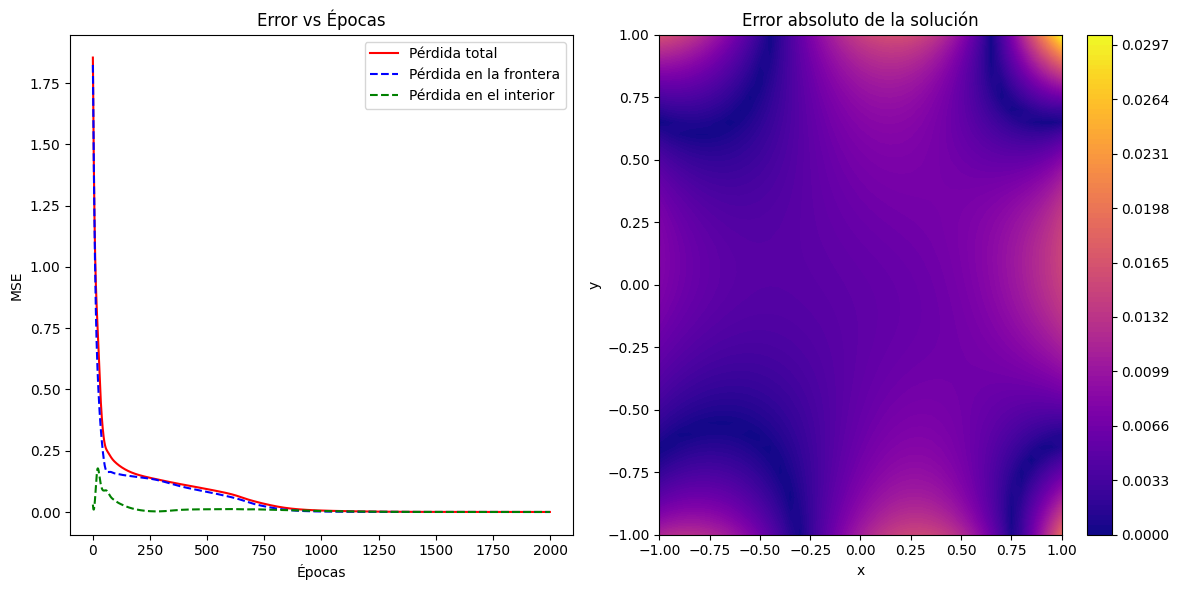

In [18]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
ax1.plot(range(epochs), loss_h, '-r', label='Pérdida total')
ax1.plot(range(epochs), u_loss_h, '--b', label='Pérdida en la frontera')
ax1.plot(range(epochs), f_loss_h, '--g', label='Pérdida en el interior')
ax1.set_title('Error vs Épocas')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('MSE')
ax1.legend()

#-----------------------#
ax2 = fig.add_subplot(122)

err = np.abs(up_star - up_pred)
err = griddata(Xp_star, err.flatten(), (XP, YP), method='linear')

cf = ax2.contourf(xp, yp, err, levels=100, cmap='plasma')
plt.colorbar(cf, ax=ax2)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Error absoluto de la solución')

plt.tight_layout()
plt.savefig('Err_Analysis')
plt.show()